# Import modules

In [ ]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from scipy.sparse import diags
device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seeds
random.seed(1)
np.random.seed(1)

torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ativate GPU if needed
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Get latex commands
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [ ]:
plt.rcParams['text.usetex'] = True

# Define initial parameters

In [ ]:
#Space grid (same for all dimension), nleft bound, right bound, and number of points
lb = 0
rb = 1
n_x = 32

#Define data points number
m = 100

#Data oscillations (how many sin/cos waves to superpose) and initial coeficient bound
c_1 = 20
k = 4

#Number of output times
t_k = 5

#Boundary conditions type (inactive for now - Dirichlet zero boundaries in place)
Boundary_cond = 'Dirichlet'
#Boundary conditions if Dirichlet (inactive for now - Dirichlet zero boundaries in place)
T_0 = 0
T_1 = 0

#Coefficients cap
max_a = 2.5
max_b = 2.5
#Epsilon value (for coefficient and model parameter caps)
epsilon = 0.0001

#Maximum coarsening factor for experiments
coars_max = 8

#Optimization parameters: regularization, batch size, train-val-test percentage split
batch_s = 16
train_size = 0.75
val_size = 0.125

#Example soltution to plot
test_data = 19

# Define mesh, particular to the heat equation: $dt \sim dx^2$

We pick $n_t = 2\cdot dimension \cdot max(a(x,y))\cdot n_x^2$ and this will ensure stability of the Finite Differences algorithm since $\frac{a(x,y)d_t}{d_x^2} \leq \frac{max(a(x,y))d_t}{d_x^2} = \frac{1}{2\cdot dimension}$

In [ ]:
#Define space and time mesh
n_t = int(4*max_a*(n_x**3))

xmesh = torch.linspace(lb, rb, n_x).to(device)
tmesh = torch.linspace(0, 1, n_t).to(device)

dx = xmesh[1]-xmesh[0]
dt = tmesh[1]-tmesh[0]

# Define random initial conditions

Made up of a superposition of k (hyperparameter defined above) sin waves




In [ ]:
# Random initial conditions made up of a combination of sin(pi*k*x) functions - decaying as 1/k
x1, x2, x3 = np.meshgrid(xmesh.cpu(), xmesh.cpu(), xmesh.cpu())
def sin_xyz(x,y,z,i,j,k):
  return np.sin(np.pi*i*x)*np.sin(np.pi*j*y)*np.sin(np.pi*k*z)

coef_vector = torch.ones((k,k,k)).to(device)
for i in range(k):
  for j in range(k):
    for l in range(k):
      if ((i<=1) and (j<=1) and (l<=1)):
        coef_vector[i][j][l] = 1
      else:
        coef_vector[i][j][l] = 0

def initial_cond_dirichlet(x_mesh,k):
  coefs_rand = (torch.rand((k,k,k))-0.5).to(device)
  coefs_actual = coef_vector*coefs_rand
  func=torch.zeros((len(x_mesh),len(x_mesh),len(x_mesh))).to(device)
  for i in range(1, k+1):
    for j in range(1,k+1):
      for l in range(1,k+1):
        func+=(coefs_actual[i-1][j-1][l-1]*torch.tensor(sin_xyz(x1,x2,x3,i,j,l)).to(device))

  max = torch.max(func)
  min = torch.min(func)
  func = 2*func/(max-min)
  coefs_actual = 2*coefs_actual/(max-min)
  return func, coefs_actual

## Define the coeficients for the equatiion to model: $u_t = a(x,y)(u_{xx}+u_{yy})$

Capped between max_a and zero to ensure stability (hyperparameters defined above). The epsilon value just ensures the caps are not attained so that the model can learn the parameters exactly





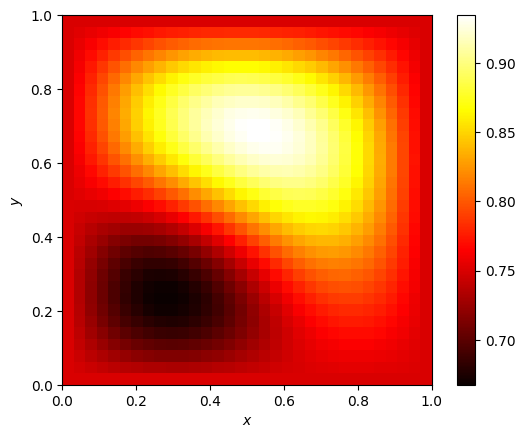

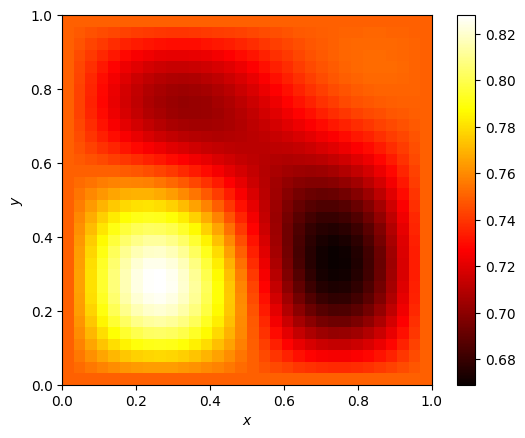

In [ ]:
#Define 2D grid and return evaluated coefficient values
a_xyz = initial_cond_dirichlet(xmesh,k)[0].to(device)+0.75
a_xyz = torch.maximum(torch.minimum(a_xyz, torch.tensor(max_a - epsilon)), torch.tensor(epsilon))

b_xyz = initial_cond_dirichlet(xmesh, k)[0].to(device) + 0.75
#Visualize the coefficients (also an example of initial conditions)

plt.imshow(a_xyz[1].cpu(), cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.imshow(b_xyz[1].cpu(), cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [ ]:
#Construct the data of initial conditions
coefficients = torch.zeros((m, k, k, k)).to(device)
initial_conditions = torch.zeros(m, n_x, n_x, n_x).to(device)
for j in range(m):
  function, coefs = initial_cond_dirichlet(xmesh, k)
  initial_conditions[j]= function
  coefficients[j] = coefs

# Fully resolved finite difference method, later coarsened
- first run the fully resolved FD method
- then averaged down to coarse mesh
- average in space x-factor adjacent grid points
- sample in time, (the t-factor time step)


In [ ]:
#Define inputs and outputs of neural net which are PDE intitial condition and averaged solution at t=1,..,t_k respectively

#Maximum time value to generate data for
t_max = coars_max**2*t_k+1
solutions_exact = torch.zeros((1, t_max, n_x, n_x, n_x)).to(device)

filter = torch.tensor([[[0,0,0],[0,1,0],[0,0,0]],
                      [[0,1,0],[1,-6,1],[0,1,0]],
                      [[0,0,0],[0,1,0],[0,0,0]]]
                      ).float().to(device)
one_filter = torch.tensor([[1]]).float().to(device)
#Loop over all initial conditions (data points)
for j in range(m):
  #Create FD solution with initial condition
  sol = torch.zeros((t_max, n_x, n_x, n_x)).to(device)
  sol[0]=initial_conditions[j]

  #Solve forward in time (full grid) using finite differences
  for i in range(1, t_max):
    inp_pad = F.pad(sol[i-1].unsqueeze(0), (1,)*6, mode='circular')
    convolution = F.conv3d(inp_pad.unsqueeze(0), filter.unsqueeze(0).unsqueeze(0), padding = 0)/(dx**3)
    upwind = torch.maximum(b_xyz,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],-1)-sol[i-1])
    downwind = 0-torch.minimum(b_xyz,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],1)-sol[i-1])
    sol[i] = sol[i-1] + dt*(convolution)*a_xyz + upwind + downwind

  #Add to solutions tensor
  solutions_exact = torch.cat((solutions_exact, sol.view(1, t_max, n_x, n_x, n_x)), 0)


In [ ]:
import torch
A = torch.arange(0,16).view(1,4,4)
print("2D")
print(A)
print(torch.roll(A, -1,dims=-1))
print(torch.roll(A, -1,dims=-2))



2D
tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]]])
tensor([[[ 1,  2,  3,  0],
         [ 5,  6,  7,  4],
         [ 9, 10, 11,  8],
         [13, 14, 15, 12]]])
tensor([[[ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15],
         [ 0,  1,  2,  3]]])


In [ ]:
#Construct the OOD data from a different spectrum
OOD_spec = torch.ones((k,k,k)).to(device)
for i in range(k):
  for j in range(k):
    for l in range(k):
      if ((i>=2) and (j>=2) and (l>=2)):
        OOD_spec[i][j][l] = 1
      else:
        # OOD_spec[i][j] = 1/(np.sqrt((3-i)**2+(3-j)**2))
        OOD_spec[i][j][l] = 0

def initial_cond_OOD(x_mesh,k):
  coefs_rand = (torch.rand((k,k,k))-0.5).to(device)
  coefs_actual = OOD_spec*coefs_rand
  func=torch.zeros((len(x_mesh),len(x_mesh), len(x_mesh))).to(device)
  for i in range(1, k+1):
    for j in range(1,k+1):
      for l in range(1,k+1):
        func+=(coefs_actual[i-1][j-1][l-1]*torch.tensor(sin_xyz(x1,x2,x3,i,j,l)).to(device))

  max = torch.max(func)
  min = torch.min(func)
  func = 2*func/(max-min)
  coefs_actual = 2*coefs_actual/(max-min)
  return func, coefs_actual

coefficients_OOD = torch.zeros((50, k, k, k)).to(device)
initial_conditions_OOD = torch.zeros(50, n_x, n_x, n_x).to(device)
for j in range(50):
  function, coefs = initial_cond_OOD(xmesh, k)
  initial_conditions_OOD[j]= function
  coefficients_OOD[j] = coefs

In [ ]:
#Define an out of distribution data point (i.e. 2 oscillations instead of 4)
solutions_exact_OOD = torch.zeros((1,t_max,n_x,n_x,n_x)).to(device)

for j in range(50):
  sol = torch.zeros((t_max,n_x,n_x,n_x)).to(device)
  sol[0]=initial_conditions_OOD[j]

  for i in range(1, t_max):
    inp_pad = F.pad(sol[i-1].unsqueeze(0), (1,)*6, mode='circular')
    convolution = F.conv3d(inp_pad.unsqueeze(0), filter.unsqueeze(0).unsqueeze(0), padding = 0)/(dx**3)
    upwind = torch.maximum(b_xyz,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],-1)-sol[i-1])
    downwind = 0-torch.minimum(b_xyz,torch.tensor(0))*dt/dx*(torch.roll(sol[i-1],1)-sol[i-1])
    sol[i] = sol[i-1] + dt*(convolution)*a_xyz + upwind + downwind

  solutions_exact_OOD = torch.cat((solutions_exact_OOD, sol.view(1,t_max,n_x,n_x,n_x)), 0)

In [ ]:
print(solutions_exact_OOD[0].shape)

torch.Size([321, 32, 32, 32])


##Coarsening:

Coarsen the space grid by x_factor defined below and sample solutions at the t_factor which corresponds to $x\_factor^2$ for stability

In [ ]:
#Factor by which to coarsen x-grid and new number of grid points (for easier to read code later)
x_factor = 2
n_x_new = int(n_x/x_factor)
#Corresponding t_factor
t_factor = x_factor**2

In [ ]:
from traitlets.config.application import T
#Define the coarsening function using pooling layers and ensuring the Dirichlet zero boundary conditions
def coarsen(sol, n_x, x_factor):
  sol_avg = torch.zeros((t_k, n_x_new, n_x_new, n_x_new)).to(device)

  #For each output average pool the values and then add the boundary conditions
  for t in range(t_k):
    sol_avg[t] = F.avg_pool3d(sol[t_factor*(t+1)].unsqueeze(0),x_factor)
    sol_avg[t] = F.pad(sol_avg[t,1:-1,1:-1,1:-1].unsqueeze(0), (1,)*6, mode='circular')
    #sol_avg[t][:,:,0] = 0
    #sol_avg[t][:,:,-1] = 0
    #sol_avg[t][0,:,:] = 0
    #sol_avg[t][-1,:,:] = 0
    #sol_avg[t][:,0,:] = 0
    #sol_avg[t][:,-1,:] = 0

  #For the input average pool the values and then add the boundary conditions
  inp_avg = F.avg_pool3d(sol[0].unsqueeze(0),x_factor)
  inp_avg = F.pad(inp_avg[0,1:-1,1:-1,1:-1].unsqueeze(0), (1,)*6, mode='circular')
  #inp_avg[0][:,:,0] = 0
  #inp_avg[0][:,:,-1] = 0
  #inp_avg[0][0,:,:] = 0
  #inp_avg[0][-1,:,:] = 0
  #inp_avg[0][:,0,:] = 0
  #inp_avg[0][:,-1,:] = 0

  return inp_avg, sol_avg


In [ ]:
#Define the inputs and outputs of the model (inputs are the initial conditons coarsened and
#outputs are the outputs at the sampled times coarsened in space too)
inputs = torch.zeros((1, n_x_new, n_x_new, n_x_new)).to(device)
outputs = torch.zeros((1, t_k, n_x_new, n_x_new, n_x_new)).to(device)

for j in range(1, m+1):
  # Coarsen the solution
  inp_avg, sol_avg = coarsen(solutions_exact[j], n_x, x_factor)

  #Conactenate our input-output pair to the respective tensors
  inputs = torch.cat((inputs, inp_avg.view(1, n_x_new, n_x_new, n_x_new)), 0)
  outputs = torch.cat((outputs, sol_avg.view(1, t_k, n_x_new, n_x_new, n_x_new)),0)

# Format data into pytorch data_loaders

In [ ]:
# Add an extra dimension to inputs for mathematical stability of matrices
inputs = torch.unsqueeze(inputs,1)

In [ ]:
# Chek input and output sizes
print(inputs.size())
print(outputs.size())

torch.Size([101, 1, 16, 16, 16])
torch.Size([101, 5, 16, 16, 16])


In [ ]:
# Format data into datsets and then load them as dataloaders with batch size 16 (this can change)
Data_heat = TensorDataset(inputs, outputs)

Data_heat_train, Data_heat_val, Data_heat_test = torch.utils.data.random_split(Data_heat,
 [int(m*train_size)+1, int(m*val_size), m-int(m*train_size)-int(m*val_size)])

Heat_DataLoader_train = DataLoader(Data_heat_train, batch_size=batch_s, shuffle=True)
Heat_DataLoader_val = DataLoader(Data_heat_val, batch_size=batch_s, shuffle=True)
Heat_DataLoader_test = DataLoader(Data_heat_test, batch_size=batch_s, shuffle=True)

In [ ]:
#Define inputs and outputs
inputs_OOD = torch.zeros((1,n_x_new, n_x_new,n_x_new)).to(device)
outputs_OOD = torch.zeros((1,t_k,n_x_new, n_x_new,n_x_new)).to(device)

for j in range(50):
  # Coarsen the solution
  inp_avg, sol_avg = coarsen(solutions_exact_OOD[j], n_x, x_factor)

  #Conactenate our input-output pair to the respective tensors
  inputs_OOD = torch.cat((inputs_OOD, inp_avg.view(1,n_x_new,n_x_new,n_x_new)), 0)
  outputs_OOD = torch.cat((outputs_OOD, sol_avg.view(1,t_k,n_x_new,n_x_new,n_x_new)),0)

inputs_OOD = torch.unsqueeze(inputs_OOD,1)

In [ ]:
# Format data into datsets and then load them as dataloaders
Data_heat_OOD = TensorDataset(inputs_OOD, outputs_OOD)
Heat_DataLoader_OOD = DataLoader(Data_heat_OOD, batch_size=batch_s, shuffle=True)

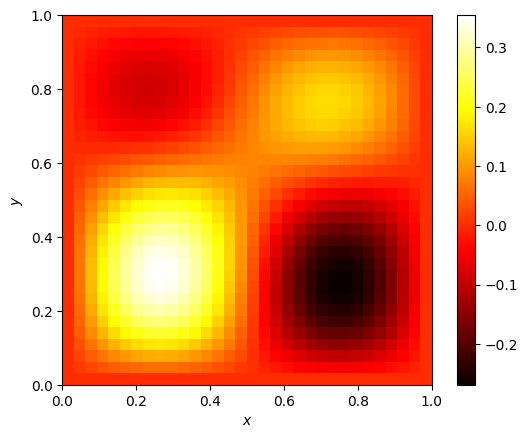

In [ ]:
#Subgrid example for Thesis
fine = solutions_exact[77]
coarse, _ = coarsen(fine, n_x, x_factor)

#Visualize the coefficients (also an example of initial conditions)
plt.imshow(fine.cpu()[0][2], cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

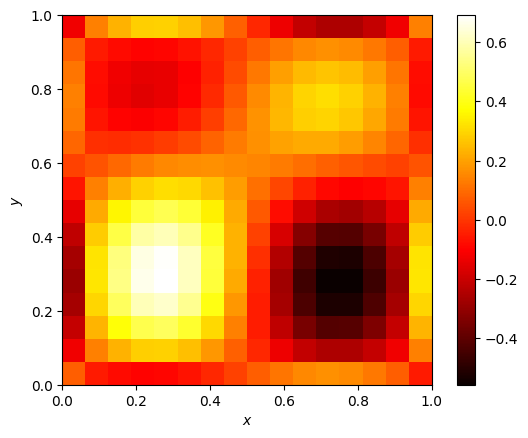

In [ ]:
#Thesis - coarsening
plt.imshow(coarse.cpu()[0][2], cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [ ]:
from numpy.lib.twodim_base import vander
from numpy.lib.shape_base import apply_over_axes
# Define the Coarsened FD method as a neural net
class IndividualLayer_PDE(nn.Module):
  """This class implements an individual layer of the coarsened grid FD method"""

  def __init__(self, grid_size):
    """
      grid_size: int
        size of coarsened grid
    """
    super(IndividualLayer_PDE, self).__init__()

    #Define convolution filter corresponding to the heat equation partial derivatives
    self.filter = torch.tensor([[[0,0,0],[0,1,0],[0,0,0]],
                      [[0,1,0],[1,-6,1],[0,1,0]],
                      [[0,0,0],[0,1,0],[0,0,0]]]
                      ).float().to(device)
    #Define convolution filter of 1 to add the zero boundary condition
    self.one_filter = torch.tensor([[1]]).float().to(device)

    # Initialize parameters randomly in (-0.5, 0.5)
    self.coefs_a = torch.nn.Parameter(2.5*(torch.rand(grid_size, grid_size, grid_size)-0.5))
    self.coefs_b = torch.nn.Parameter(2.5*(torch.rand(grid_size, grid_size, grid_size)-0.5))

  def forward(self, v):
    """
      x: Tensor
        Coarsened inputs at a given time

      Outputs: Returns the predicted coarsened outputs at the next time
    """
    # Bound coeficients between zero and max_a for stability
    a_xyz = max_a*torch.sigmoid(self.coefs_a)
    b_xyz = max_b*torch.tanh(self.coefs_b)

    inp_pad = F.pad(v, (1,)*6, mode='circular')
    convolution = F.conv3d(inp_pad, self.filter.unsqueeze(0).unsqueeze(0), padding = 0)
    a_xyz_prime = convolution*a_xyz

    upwind = torch.maximum(b_xyz,torch.tensor(0))*dt/dx*(torch.roll(v,-1)-v)
    downwind = 0-torch.minimum(b_xyz,torch.tensor(0))*dt/dx*(torch.roll(v,1)-v)

    y = v + dt/(dx**3)*(a_xyz_prime) + upwind + downwind
    return y

In [ ]:
from math import nextafter
class PDE_Solver(nn.Module):
  """This class implements the Full Coarsened FD method"""

  def __init__(self, grid_size):
    """
      grid_size: int
        size of coarsened grid
    """
    super(PDE_Solver, self).__init__()

    # Call the individual layer class defined previously
    self.layer = IndividualLayer_PDE(grid_size)

  def forward(self, x):
    """
      x: Tensor
        Coarsened inputs to the network at time 0

      Outputs: Returns the coarsened outputs at the next t_k times
    """

    # Call the individual layer (FD method) t_k times to generate the next t_k time predictions in the coarsened grid
    # and concatenate the new value to the output tensor
    prev = x
    next = self.layer(prev)
    y = next
    prev = next

    for i in range(t_k-1):
      next = self.layer(prev)
      y = torch.cat((y,next),1)
      prev = next

    return y

# Define the Training and Validation for the model

In [ ]:
# Define one training epoch through the train and valudate functions
# Each call to train and validate runs a training and validation epoch
# This is generic code that serves to train and validate any ML model with Pytorch
def train(model, dataloader, optimizer, criterion):
    train_loss = 0.
    model.train()
    start = time.time()

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(source)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    end = time.time()
    train_loss /= len(dataloader)
    train_time = end - start
    return train_loss, train_time

def validate(model, dataloader, criterion):
    val_loss = 0.
    model.eval()
    start = time.time()

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        output = model(source)
        loss = criterion(output, target)
        val_loss += loss.item()

    end = time.time()
    val_loss /= len(dataloader)
    val_time = end - start
    return val_loss, val_time

# Run it / Train the Model and plot learning dynamics


In [ ]:
# Define the model as the PDE_Solver class and feed in the coarsed grid size
# Optimize with Adam and our loss is the L_2 loss
model = PDE_Solver(n_x_new).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay = 0)
criterion = torch.nn.MSELoss()

# Collect the results of the training and validation
results = {
    "train_losses": [],
    "train_times":  [],
    "valid_losses": [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_time":    0.
}

if __name__ == "__main__":
    torch.cuda.empty_cache()
    n_epochs = 1000

    for epoch in range(n_epochs):
        train_loss, train_time = train(model, Heat_DataLoader_train, optimizer, criterion)
        valid_loss, valid_time = validate(model, Heat_DataLoader_val, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_times"].append(valid_time)

    test_loss, test_time = validate(model, Heat_DataLoader_test, criterion)
    print(f"== Test Loss: {test_loss} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_time"] = test_time

Epoch: 0
Train Loss: 0.005827599018812179 | Train Time: 0.410
Valid Loss: 0.006220349110662937 | Valid Time: 0.014
Epoch: 1
Train Loss: 0.005825279466807842 | Train Time: 0.255
Valid Loss: 0.006204361096024513 | Valid Time: 0.013
Epoch: 2
Train Loss: 0.005824176780879498 | Train Time: 0.249
Valid Loss: 0.0061882855370640755 | Valid Time: 0.013
Epoch: 3
Train Loss: 0.0057684479281306265 | Train Time: 0.247
Valid Loss: 0.0061721960082650185 | Valid Time: 0.012
Epoch: 4
Train Loss: 0.005780685506761074 | Train Time: 0.261
Valid Loss: 0.006156261544674635 | Valid Time: 0.013
Epoch: 5
Train Loss: 0.005762729048728943 | Train Time: 0.253
Valid Loss: 0.006140254903584719 | Valid Time: 0.013
Epoch: 6
Train Loss: 0.005730828363448381 | Train Time: 0.255
Valid Loss: 0.006124258507043123 | Valid Time: 0.013
Epoch: 7
Train Loss: 0.005722853075712919 | Train Time: 0.250
Valid Loss: 0.00610820297151804 | Valid Time: 0.012
Epoch: 8
Train Loss: 0.005726496689021587 | Train Time: 0.258
Valid Loss: 0.00

KeyboardInterrupt: 

Text(0, 0.5, 'MSE')

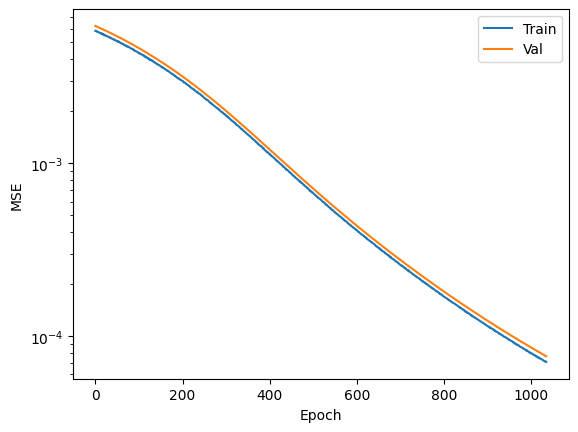

In [ ]:
# Plot the training and validation losses
plt.plot(results["train_losses"])
plt.plot(results["valid_losses"])
plt.legend(['Train', 'Val'])
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [ ]:
print(model.parameters())
for param_test in model.parameters():
  print(param_test.shape)

<generator object Module.parameters at 0x7a32cbfd77d0>
torch.Size([16, 16, 16])
torch.Size([16, 16, 16])


In [ ]:
# Print the learned parameters and collect the coefficients found by the model
results_coefs_a = np.zeros((n_x_new,n_x_new,n_x_new))
for i, param in enumerate(model.parameters()):
  print(param)
  if i ==0:
    for j1 in range(n_x_new):
      for j2 in range(n_x_new):
        for j3 in range(n_x_new):
          results_coefs_a[j1][j2][j3]=max_a*torch.sigmoid(param[j1][j2][j3])

In [ ]:
for i, param in enumerate(model.parameters()):
  if i == 0:
    results_coefs_a = max_a*torch.sigmoid(param)
  elif i == 1:
    results_coefs_b = max_b*torch.tanh(param)

results_coefs_a = results_coefs_a.detach().numpy()
results_coefs_b = results_coefs_b.detach().numpy()

# Plot learned coefficients agains actual coeficients

We use interpolation when comparing soltuions for more coarsened grids

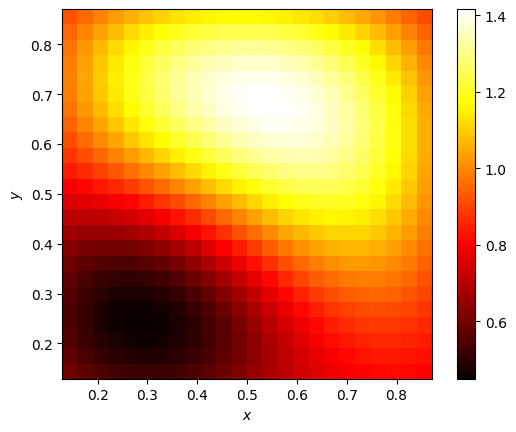

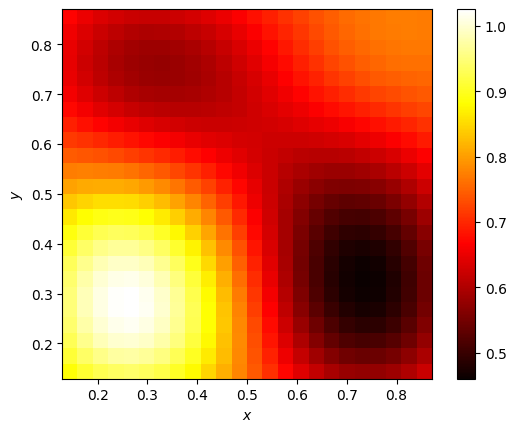

In [ ]:
#Visualize actual coefficients again
plt.imshow(a_xyz.cpu()[4][2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()
plt.imshow(b_xyz.cpu()[4][2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [ ]:
import scipy
#Get the averaged mesh values in one dimension (since it is a rectangular grid it is the same in all dimensions)
x_mesh_avg = torch.zeros(n_x_new).to(device)
for i in range(n_x_new):
  x_mesh_avg[i] = torch.mean(xmesh[x_factor*i:x_factor*(i+1)])
x_mesh_avg[0]=0
x_mesh_avg[-1]=1

In [ ]:
#Interpolate the results to the fine grid using linear interpolation (excluding last two coeficients due to boundary condition redundancy)
interp2d_coefs = scipy.interpolate.RegularGridInterpolator((x_mesh_avg[2:-2].cpu(), x_mesh_avg[2:-2].cpu()),
                                                           results_coefs_a[4][2:-2, 2:-2], bounds_error=False, fill_value=None)
xx1, xx2 = np.meshgrid(xmesh.cpu(), xmesh.cpu())

interpolated_coefs_a = interp2d_coefs((xx2, xx1))

In [ ]:
#Interpolate the results to the fine grid using linear interpolation (excluding last two coeficients due to boundary condition redundancy)
interp2d_coefs = scipy.interpolate.RegularGridInterpolator((x_mesh_avg[2:-2].cpu(), x_mesh_avg[2:-2].cpu()),
                                                           results_coefs_b[4][2:-2, 2:-2], bounds_error=False, fill_value=None)
xx1, xx2 = np.meshgrid(xmesh.cpu(), xmesh.cpu())

interpolated_coefs_b = interp2d_coefs((xx2, xx1))

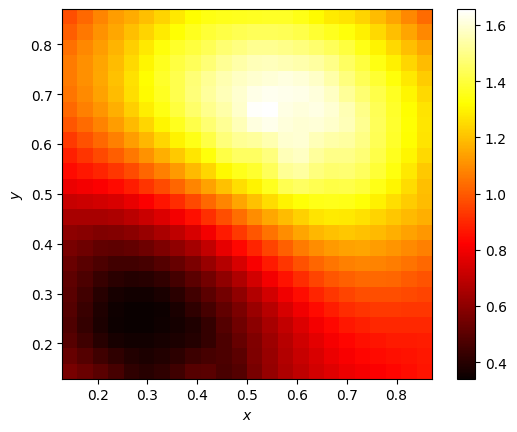

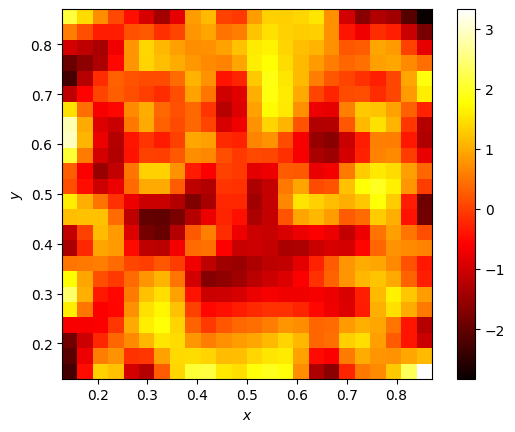

In [ ]:
#Viasualize the learned coefficients
plt.imshow(interpolated_coefs_a[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

plt.imshow(interpolated_coefs_b[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

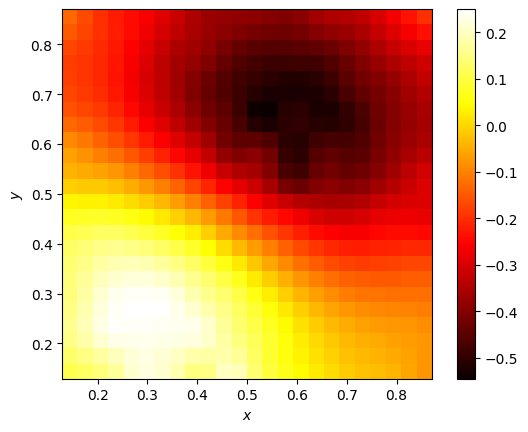

In [ ]:
#Plot the difference between the actual and learned coeffcients
plt.imshow(a_xyz.cpu()[2][2*x_factor:-2*x_factor,2*x_factor:-2*x_factor]-interpolated_coefs_a[2*x_factor:-2*x_factor,2*x_factor:-2*x_factor], cmap='hot', origin='lower',
           extent=[2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu(), 2*x_factor*dx.cpu(), (n_x-2*x_factor-1)*dx.cpu()])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

# Plot an example of a modelled solution against its fully resolved function

Again interpolating to the fine grid for the modelled solution

In [ ]:
# Plot an example solution
sol_model_act = solutions_exact[test_data]

#Sample our solution to t_k time steps
sol_model_act_avg = torch.zeros((t_k, n_x, n_x, n_x)).to(device)
for i in range (t_k):
  sol_model_act_avg[i] = sol_model_act[t_factor*(i+1)]

#Our modelled solution is just the output of the netweork to this coarsened input
sol_model_pred = model(inputs[test_data].unsqueeze(0)).squeeze(0).detach().cpu().numpy()

In [ ]:
#Interpolate our solution to the fine grid
test_time = 0
interp2d_sol = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                         sol_model_pred[test_time][2], bounds_error=False, fill_value=None)
interpolated_sol = interp2d_sol((xx2, xx1))

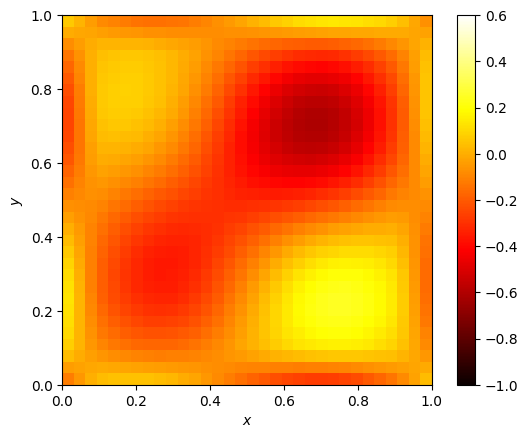

In [ ]:
#Plot our solutions to compare - modelled solution at first predicted time
plt.imshow(interpolated_sol, cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=-1, vmax=0.6)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

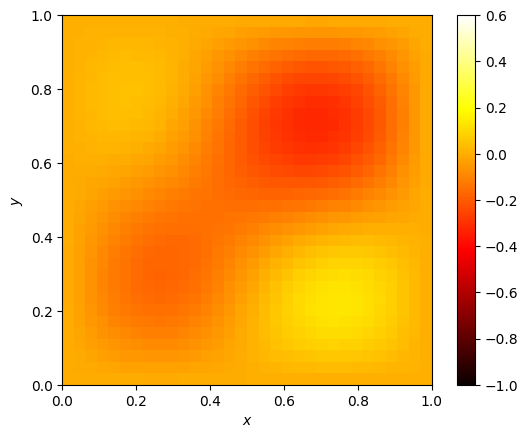

In [ ]:
#Plot our solutions to compare - actual solution at first predicted time
plt.imshow(sol_model_act_avg[test_time][2].cpu(), cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=-1, vmax=0.6)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

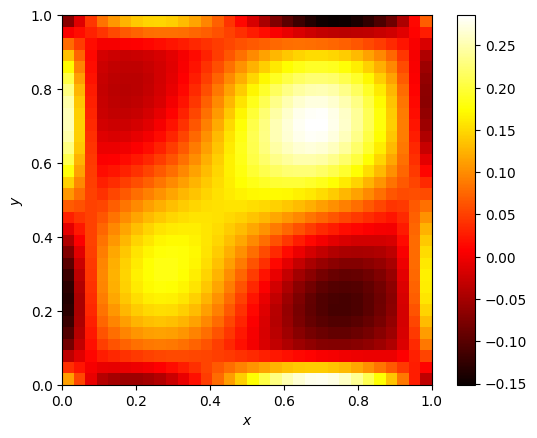

In [ ]:
#Plot our solutions to compare - difference in solutions at first predicted time
plt.imshow(sol_model_act_avg[test_time,2].cpu()-interpolated_sol, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [ ]:
#Maximum discrepancy between solutions at first predicted time
F.mse_loss(sol_model_act_avg[0],torch.tensor(interpolated_sol).to(device))


<ipython-input-155-d378bda8295e>:2: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(sol_model_act_avg[0],torch.tensor(interpolated_sol).to(device))


tensor(0.1180, dtype=torch.float64)

# Now we train a fuly connected neural net

## Working with the heat equaiton $$u_t = a(x,y)(u_{xx}+u_{yy})$$

Input data - Initial conditions

For now working with Zero-Dirichlet Boundary conditions

Initial conditions: $$u((x,y),0) = \sum_{i=1}^k \sum_{j=1}^kc_{ij}sin(\pi ix)\cdot sin(\pi jy)$$

$k = 2$ for the results presented today (note that larger $k$ values require finer grid size $n_x$ to generate good results).


In [ ]:
# Define the Coarsened FD method as a fully connected neural net
# Option 1: run the coede as is for the Convolutional neural netword
# Option 2: uncomment the section under #Define a simple 2-layer ReLU MLP, the comment # x = self.flatten(x) and the comment
# # y = y.view(-1, 1, self.grid_size, self.grid_size), and comment out the section under #Define a simple 2-layer ReLU conv net
# to run the fully connected network
class IndividualLayer_NN(nn.Module):
  """This class implements an individual layer of the coarsened grid FD method"""

  def __init__(self, grid_size):
    """
      grid_size: int
        size of coarsened grid
    """
    super(IndividualLayer_NN, self).__init__()

    self.grid_size = grid_size
    #Neural net is a simple fully-connected two-layer neural net with ReLU activation (i.e. we first flatten the inputs from a 2D array to a 1D array)
    # self.layer1 = nn.Conv2d(1, 16, 3, 1, 1)
    # self.activation = nn.ReLU()
    # self.layer2 = nn.Conv2d(16, 1, 3, 1, 1)

    #Define a simple 2-layer ReLU MLP
    self.flatten = nn.Flatten()
    self.layer1 = nn.Linear(self.grid_size**2, 32)
    self.activation = nn.ReLU()
    self.layer2 = nn.Linear(32, self.grid_size**2)


  def forward(self, x):
    """
      x: Tensor
        Coarsened inputs at a given time

      Outputs: Returns the predicted coarsened outputs at the next time
    """
    x = self.flatten(x)
    #Conv layer 1
    x2 = self.layer1(x)
    #ReLU
    x3 = self.activation(x2)
    #Conv layer 2
    y = self.layer2(x3)
    #Re-shape to 2D array
    y = y.view(-1, 1, self.grid_size, self.grid_size)
    return y

In [ ]:
class NN_Solver(nn.Module):
  """This class implements the Full Coarsened FD method"""

  def __init__(self, xmesh):
    """
      xmesh: int
        size of coarsened grid
      W: matrix
        Matrix for the coarsened FD method
    """
    super(NN_Solver, self).__init__()

    # Call the individual layer class defined previously - currently t_k = 10, change manually if this changes
    self.layer1 = IndividualLayer_NN(xmesh)
    self.layer2 = IndividualLayer_NN(xmesh)
    self.layer3 = IndividualLayer_NN(xmesh)
    self.layer4 = IndividualLayer_NN(xmesh)
    self.layer5 = IndividualLayer_NN(xmesh)
    self.layer6 = IndividualLayer_NN(xmesh)
    self.layer7 = IndividualLayer_NN(xmesh)
    self.layer8 = IndividualLayer_NN(xmesh)
    self.layer9 = IndividualLayer_NN(xmesh)
    self.layer10 = IndividualLayer_NN(xmesh)

  def forward(self, x):
    """
      x: Tensor
        Coarsened inputs to the network at time 0

      Outputs: Returns the coarsened outputs at the next 10 times
    """

    # Call the individual layer (FD method) 10 times to generate the next t_k = 10 time predictions in the coarsened grid (as before need to clean up)
    x1=self.layer1(x)
    x2=self.layer2(x1)
    x3=self.layer3(x2)
    x4=self.layer4(x3)
    x5=self.layer5(x4)
    x6=self.layer6(x5)
    x7=self.layer7(x6)
    x8=self.layer8(x7)
    x9=self.layer9(x8)
    x10=self.layer10(x9)

    # Concatenate the outputs to check with the original coarsened outputs
    y = torch.cat((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10),1)
    return y

In [ ]:
# Define the model as the PDE_Solver class and feed in the coarsed grid size and average W matrix
# Optimize with Adam and our loss is the L_2 loss
# Note that a regularization of 0.0001 is used when the grid reslution is 64 x 64 to prevent the model from blowing up
modelNN = NN_Solver(n_x_new).to(device)
optimizer = optim.Adam(modelNN.parameters(), weight_decay=0)
criterion = torch.nn.MSELoss()

# Collect the results of the training and validation
resultsNN = {
    "train_losses": [],
    "train_times":  [],
    "valid_losses": [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_time":    0.
}

if __name__ == "__main__":
    torch.cuda.empty_cache()
    n_epochs = 1000

    for epoch in range(n_epochs):
        train_loss, train_time = train(modelNN, Heat_DataLoader_train, optimizer, criterion)
        valid_loss, valid_time = validate(modelNN, Heat_DataLoader_val, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss} | Valid Time: {valid_time:.3f}")

        resultsNN["train_losses"].append(train_loss)
        resultsNN["train_times"].append(train_time)
        resultsNN["valid_losses"].append(valid_loss)
        resultsNN["valid_times"].append(valid_time)

    test_loss, test_time = validate(modelNN, Heat_DataLoader_test, criterion)
    print(f"== Test Loss: {test_loss} | Test Time: {test_time:.3f} ==")
    resultsNN["test_loss"] = test_loss
    resultsNN["test_time"] = test_time

Epoch: 0
Train Loss: 0.14792368113994597 | Train Time: 0.091
Valid Loss: 0.12577657401561737 | Valid Time: 0.003
Epoch: 1
Train Loss: 0.13971532359719277 | Train Time: 0.049
Valid Loss: 0.12718763202428818 | Valid Time: 0.003
Epoch: 2
Train Loss: 0.1370931401848793 | Train Time: 0.045
Valid Loss: 0.12344814836978912 | Valid Time: 0.003
Epoch: 3
Train Loss: 0.13071414232254028 | Train Time: 0.046
Valid Loss: 0.11692864447832108 | Valid Time: 0.003
Epoch: 4
Train Loss: 0.12531937062740325 | Train Time: 0.051
Valid Loss: 0.11220837011933327 | Valid Time: 0.004
Epoch: 5
Train Loss: 0.1172144241631031 | Train Time: 0.048
Valid Loss: 0.10163653641939163 | Valid Time: 0.003
Epoch: 6
Train Loss: 0.10783922895789147 | Train Time: 0.049
Valid Loss: 0.09520941600203514 | Valid Time: 0.004
Epoch: 7
Train Loss: 0.09798751845955848 | Train Time: 0.050
Valid Loss: 0.08638596534729004 | Valid Time: 0.004
Epoch: 8
Train Loss: 0.08789567574858666 | Train Time: 0.052
Valid Loss: 0.07481284067034721 | Val

Text(0, 0.5, 'MSE')

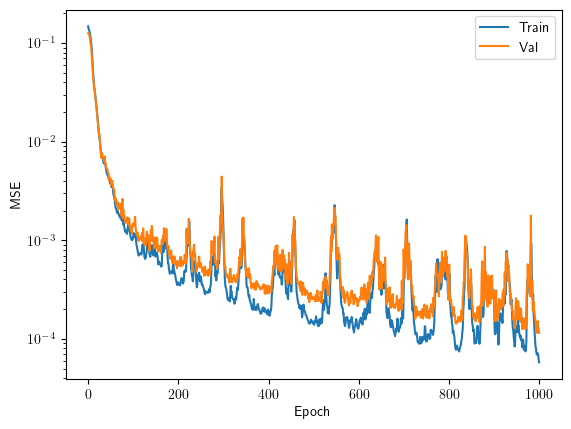

In [ ]:
# Plot the training and validation losses
plt.plot(resultsNN["train_losses"])
plt.plot(resultsNN["valid_losses"])
plt.legend(['Train', 'Val'])
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('MSE')

In [ ]:
# Plot an example solution
sol_model_act = solutions_exact[test_data]

#Sample our solution to t_k time steps
sol_model_act_avg = torch.zeros((t_k, n_x, n_x)).to(device)
for i in range (t_k):
  sol_model_act_avg[i] = sol_model_act[t_factor*(i+1)]

#Our modelled solution is just the output of the netweork to this coarsened input
sol_model_pred_NN = modelNN(inputs[test_data].unsqueeze(0)).squeeze().detach().cpu().numpy()

In [ ]:
#Interpolate our solution to the fine grid
test_time = 0
interp2d_solNN = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                       sol_model_pred_NN[test_time], bounds_error=False, fill_value=None)
interpolated_solNN = interp2d_solNN((x2, x1))

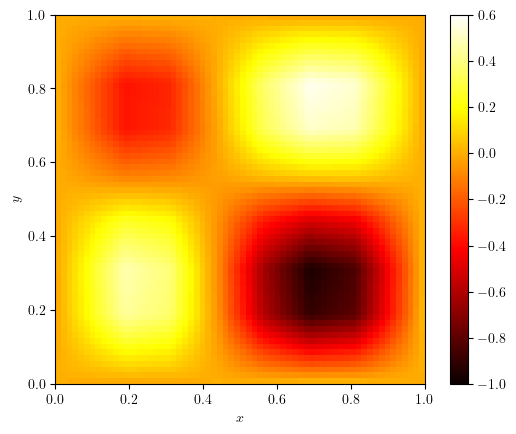

In [ ]:
#Plot our solutions to compare - modelled solution at first predicted time
plt.imshow(interpolated_solNN, cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=-1, vmax=0.6)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

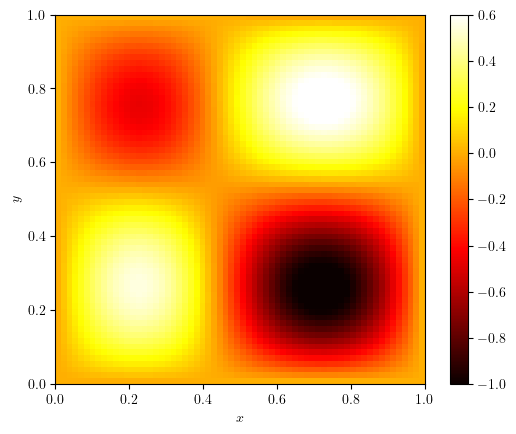

In [ ]:
#Plot our solutions to compare - exact solution at first predicted time
plt.imshow(sol_model_act_avg.cpu()[test_time], cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=-1, vmax=0.6)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

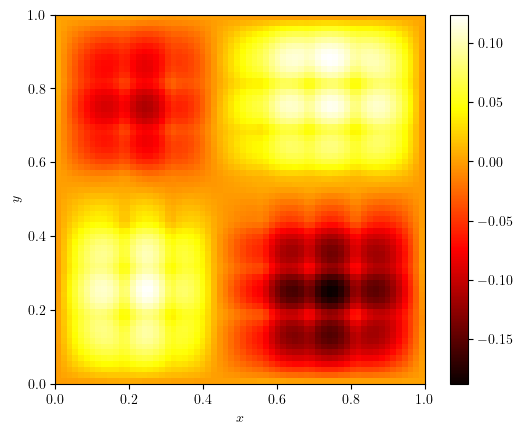

In [ ]:
#Plot our solutions to compare - dufference at first predicted time
plt.imshow(sol_model_act_avg[test_time].cpu()-interpolated_solNN, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [ ]:
#Maximum discrepancy between solutions at first predicted time
F.mse_loss(sol_model_act_avg[0], torch.tensor(interpolated_solNN).to(device))

tensor(0.0041, device='cuda:0', dtype=torch.float64)

In [ ]:
#Get OOD losses
test_loss_OOD, test_time_OOD = validate(model, Heat_DataLoader_OOD, criterion)
test_loss_OOD_NN, test_time_OOD_NN = validate(modelNN, Heat_DataLoader_OOD, criterion)

In [ ]:
#Get normalization constants
u_avg_OOD = torch.mean(outputs_OOD)
u_stdev_OOD = torch.mean((outputs_OOD - u_avg_OOD)**2)

u_avg = torch.mean(outputs)
u_stdev = torch.mean((outputs - u_avg)**2)

In [ ]:
# Graph subgrids - note that this was done accros several runs, and the code needs to be uncommented and commented as needed
#to avoid overwriting the arrays and depending on the neural network model being run
factors = np.array([4096,1024,216,64])
losses_PDE_train = np.ones(4)
losses_PDE = np.ones(4)
losses_PDE_OOD = np.ones(4)
losses_NN_train = np.ones(4)
losses_NN = np.ones(4)
losses_NN_OOD = np.ones(4)
losses_Conv_train = np.ones(4)
losses_Conv = np.ones(4)
losses_Conv_OOD = np.ones(4)

In [ ]:
#Graph subgrids (adjust run and model as needed)
run = 3
losses_PDE_train[run-1] = (results["train_losses"][-1]/u_stdev)**0.5
losses_PDE[run-1] = (results["test_loss"]/u_stdev)**0.5
losses_PDE_OOD[run-1] = (test_loss_OOD/u_stdev_OOD)**0.5
# losses_NN_train[run-1] = (resultsNN["train_losses"][-1]/u_stdev)**0.5
# losses_NN[run-1] = (resultsNN["test_loss"]/u_stdev)**0.5
# losses_NN_OOD[run-1] = (test_loss_OOD_NN/u_stdev_OOD)**0.5
losses_Conv_train[run-1] = (resultsNN["train_losses"][-1]/u_stdev)**0.5
losses_Conv[run-1] = (resultsNN["test_loss"]/u_stdev)**0.5
losses_Conv_OOD[run-1] = (test_loss_OOD_NN/u_stdev_OOD)**0.5

In [ ]:
import matplotlib

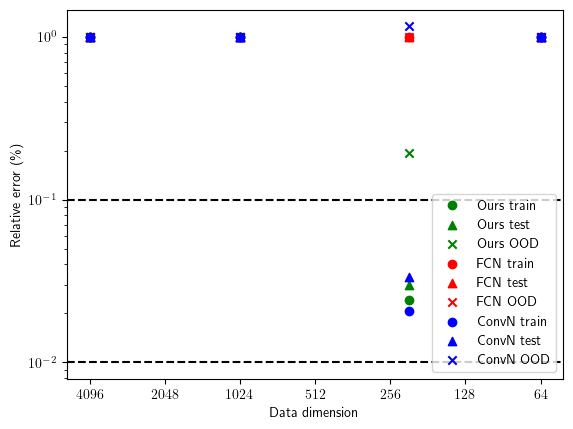

In [ ]:
#Graph subgrids
import matplotlib.ticker as mticker
plt.rc('axes.formatter', useoffset=False)

plt.scatter(factors, losses_PDE_train, c = 'green')
plt.scatter(factors, losses_PDE, c = 'green', marker = '^')
plt.scatter(factors, losses_PDE_OOD, c = 'green', marker = 'x')
plt.scatter(factors, losses_NN_train, c = 'red')
plt.scatter(factors, losses_NN, c = 'red', marker = '^')
plt.scatter(factors, losses_NN_OOD, c = 'red', marker = 'x')
plt.scatter(factors, losses_Conv_train, c = 'blue')
plt.scatter(factors, losses_Conv, c = 'blue', marker = '^')
plt.scatter(factors, losses_Conv_OOD, c = 'blue', marker = 'x')
plt.legend(['Ours train', 'Ours test', 'Ours OOD', 'FCN train', 'FCN test', 'FCN OOD', 'ConvN train', 'ConvN test', 'ConvN OOD'], loc = 4)

plt.xlabel('Data dimension')
plt.ylabel('Relative error (\%)')
plt.yscale('log')
plt.xscale('log', base = 2)
ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().invert_xaxis()

plt.axhline(y = 0.1, color = 'black', linestyle = '--')
plt.axhline(y = 0.01, color = 'black', linestyle = '--')

plt.show()

In [ ]:
#Sample our solution to t_k time steps
visual = 9
OOD_avg = torch.zeros((t_k, n_x, n_x, n_x)).to(device)
for i in range (t_k):
  OOD_avg[i] = solutions_exact_OOD[visual][t_factor*(i+1)]

#Our modelled solution is just the output of the netweork to this coarsened input for both models
OOD_pred_RCNN = model(inputs_OOD[visual+1].unsqueeze(0)).squeeze().detach().cpu().numpy()
#OOD_pred_NN = modelNN(inputs_OOD[visual+1].unsqueeze(0)).squeeze().detach().cpu().numpy()

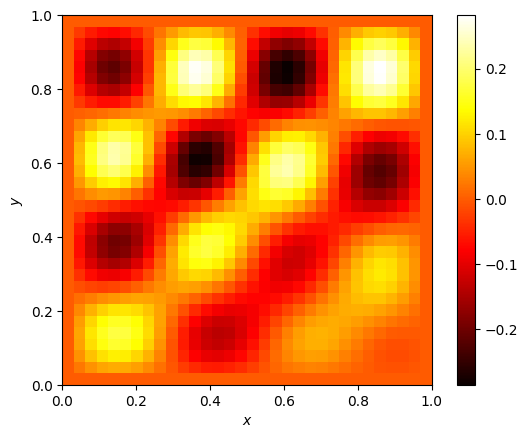

In [ ]:
test_time = 4
#Plot our solutions to compare - actual solution at first predicted time
plt.imshow(OOD_avg[test_time][2].cpu(), cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

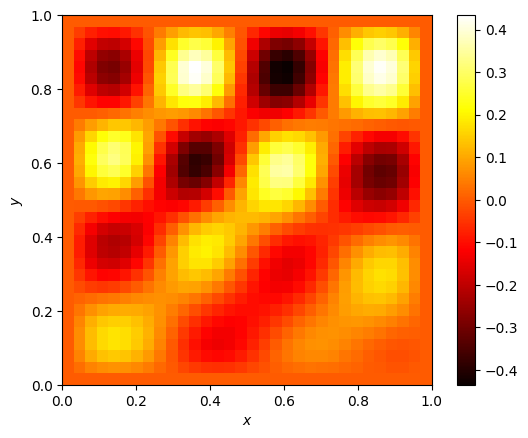

In [ ]:
#Plot our solutions to compare
interp2d_ood = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                         OOD_pred_RCNN[test_time][2], bounds_error=False, fill_value=None)
interpolated_ood = interp2d_ood((xx2, xx1))

#Plot our solutions to compare - predicted solution at first predicted time
plt.imshow(interpolated_ood, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

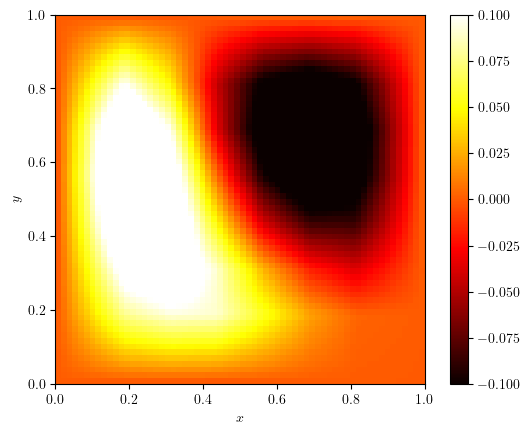

In [ ]:
#Interpolate our solution to the fine grid
interp2d_oodNN = scipy.interpolate.RegularGridInterpolator((x_mesh_avg.cpu(), x_mesh_avg.cpu()),
                                                          OOD_pred_NN[test_time], bounds_error=False, fill_value=None)
interpolated_oodNN = interp2d_oodNN((x2, x1))

#Plot our solutions to compare - predicted solution at first predicted time
plt.imshow(interpolated_oodNN, cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

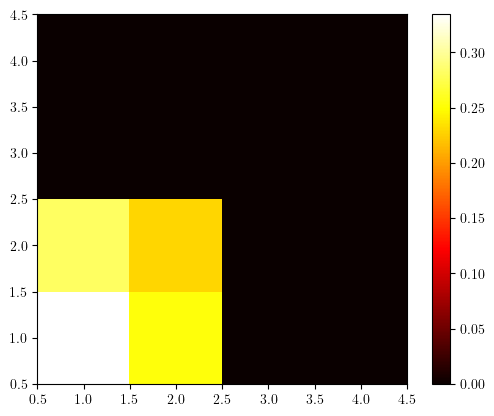

In [ ]:
#Visualize the decay of the coefficients
coefficient_mean = torch.mean(coefficients**2,0)
plt.imshow(coefficient_mean.cpu(), cmap='hot', origin='lower', extent=[0.5, 4.5, 0.5, 4.5])
plt.colorbar()

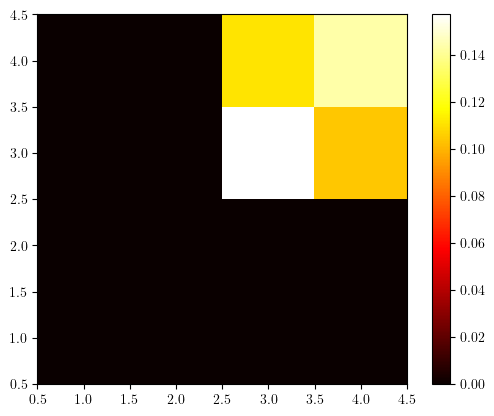

In [ ]:
#Visualize the decay of the coefficients
coefficient_mean_OOD = torch.mean(coefficients_OOD**2,0)
plt.imshow(coefficient_mean_OOD.cpu(), cmap='hot', origin='lower', extent=[0.5, 4.5, 0.5, 4.5])
plt.colorbar()

In [ ]:
#Invariance loss PDE
Loss_PDE = 0
counter = 0
for i in range(40):
  u = model(inputs[i].unsqueeze(0))
  for j in range(40):
    v = model(inputs[j].unsqueeze(0))
    sum_model = model(inputs[i].unsqueeze(0)+inputs[j].unsqueeze(0))
    sum_orig = u+v

    Loss_PDE += F.mse_loss(sum_model, sum_orig)
    counter += 1

Loss_PDE = Loss_PDE/counter
print(Loss_PDE)

#Invariance loss NN
Loss_NN = 0
counter = 0
for i in range(40):
  u = modelNN(inputs[i].unsqueeze(0))
  for j in range(40):
    v = modelNN(inputs[j].unsqueeze(0))
    sum_model = modelNN(inputs[i].unsqueeze(0)+inputs[j].unsqueeze(0))
    sum_orig = u+v

    Loss_NN += F.mse_loss(sum_model, sum_orig)
    counter += 1

Loss_NN = Loss_NN/counter
print(Loss_NN)

tensor(1.1877e-15, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
#SemiGroup loss PDE
Loss_PDE_S = 0
counter = 0
for i in range(m):
  u = model(inputs[i].unsqueeze(0)).squeeze(0)
  u_4 = [4]
  u_9_new = model(u[4].unsqueeze(0).unsqueeze(0)).squeeze(0)[4]
  u_9 = u[9]

  Loss_PDE_S += F.mse_loss(u_9_new, u_9)
  counter += 1

Loss_PDE_S = Loss_PDE_S/counter
print(Loss_PDE_S)

#SemiGroup loss NN
Loss_NN_S = 0
counter = 0
for i in range(m):
  u = modelNN(inputs[i].unsqueeze(0)).squeeze(0)
  u_4 = u[4]
  u_9_new = modelNN(u[4].unsqueeze(0).unsqueeze(0)).squeeze(0)[4]
  u_9 = u[9]

  Loss_NN_S += F.mse_loss(u_9_new, u_9)
  counter += 1

Loss_NN_S = Loss_NN_S/counter
print(Loss_NN_S)

tensor(0., device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>)
